In [8]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report, hamming_loss,
                             multilabel_confusion_matrix, f1_score)

In [9]:
root_dir = Path('.')

result_dirs = sorted(root_dir.glob('results_bert_attention_True_pos_weights_True_original_eng_*'), key=lambda x: x.name, reverse=True)

if result_dirs:
    latest_dir = result_dirs[0]
    
    csv_path = latest_dir / 'dev_predictions.csv'
    
    if csv_path.exists():
        predictions_df = pd.read_csv(csv_path)
        print("File retrieved:", csv_path)
    else:
        print(f"The CSV file does not exist in {latest_dir}")
else:
    print("No result directories found.")

emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]

File retrieved: results_bert_attention_True_pos_weights_True_original_eng_2025-02-10_10-49-52/dev_predictions.csv


In [10]:
# manual
# csv_path = 'results/validation_predictions.csv'

In [11]:
csv_path

PosixPath('results_bert_attention_True_pos_weights_True_original_eng_2025-02-10_10-49-52/dev_predictions.csv')

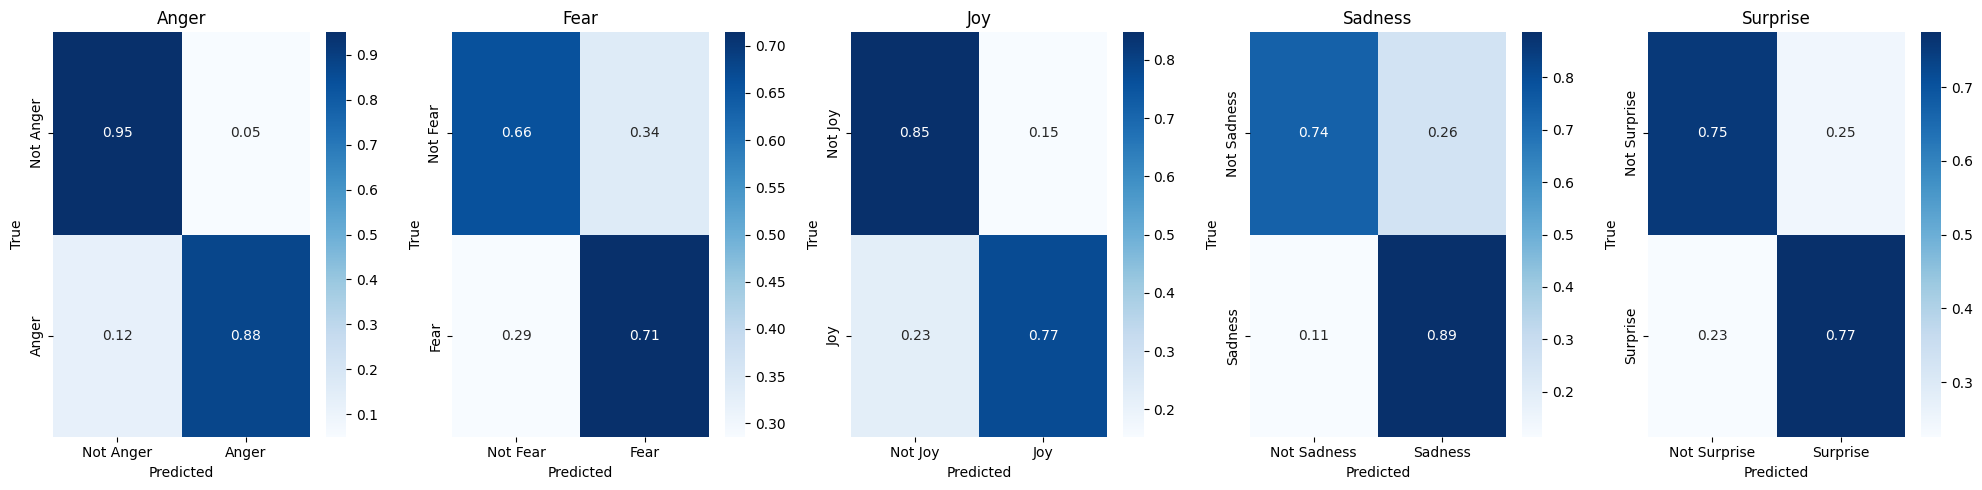

Hamming Loss: 0.2
Subset Accuracy: 0.3879310344827586


In [12]:
df = pd.read_csv(csv_path)

df["True Labels"] = df["True Labels"].apply(ast.literal_eval)
df["Predicted Labels"] = df["Predicted Labels"].apply(ast.literal_eval)

true_labels = np.array(df["True Labels"].tolist())
pred_labels = np.array(df["Predicted Labels"].tolist())

cm_per_class = multilabel_confusion_matrix(true_labels, pred_labels)

cm_per_class_normalized = []
for cm in cm_per_class:
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0
    cm_per_class_normalized.append(cm_normalized)

fig, axes = plt.subplots(1, len(emotion_labels), figsize=(20, 5))
for i, label in enumerate(emotion_labels):
    sns.heatmap(
        cm_per_class_normalized[i],
        annot=True,
        fmt=".2f",
        cmap="Blues",
        xticklabels=["Not " + label, label],
        yticklabels=["Not " + label, label],
        ax=axes[i],
    )
    axes[i].set_title(label)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
plt.tight_layout()
plt.show()

hamming = hamming_loss(true_labels, pred_labels)
subset_acc = accuracy_score(true_labels, pred_labels)

print("Hamming Loss:", hamming)
print("Subset Accuracy:", subset_acc)


In [13]:
# Classification Report
print("\nMultilabel Classification Report:")
for i, label in enumerate(emotion_labels):
    print(f"Label: {label}")
    print(classification_report(true_labels[:, i], pred_labels[:, i], zero_division=0))


Multilabel Classification Report:
Label: Anger
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       100
           1       0.74      0.88      0.80        16

    accuracy                           0.94       116
   macro avg       0.86      0.91      0.88       116
weighted avg       0.95      0.94      0.94       116

Label: Fear
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        53
           1       0.71      0.71      0.71        63

    accuracy                           0.69       116
   macro avg       0.69      0.69      0.69       116
weighted avg       0.69      0.69      0.69       116

Label: Joy
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        85
           1       0.65      0.77      0.71        31

    accuracy                           0.83       116
   macro avg       0.78      0.81      0.79       116
wei

In [14]:
# f1 macro avg
f1_macro_avg = f1_score(true_labels, pred_labels, average='macro')
f1_macro_avg

0.7128781385512463

In [15]:
f1_scores = {
    emotion: f1_score(true_labels[:, i], pred_labels[:, i], average="binary")
    for i, emotion in enumerate(emotion_labels)
}

print("F1 Scores by Emotion:")
for emotion, score in f1_scores.items():
    print(f"{emotion}: {score:.2f}")

average_f1 = np.mean(list(f1_scores.values()))
print(f"\nAverage F1 Score: {average_f1:.2f}")

F1 Scores by Emotion:
Anger: 0.80
Fear: 0.71
Joy: 0.71
Sadness: 0.71
Surprise: 0.63

Average F1 Score: 0.71
